In [ ]:
# default_exp pylightning_frcnn

# Exploring Object Detection using COCO Dataset

## Pytorch Lightning & Torch Vision

Let's start by using what's already in Torch Vision, see [example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).
To force some learning, I shall attempt to port the example to [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning) as I've read that it removes a lot of boiler plate code and standardized Pytorch usage. As well as make advanced features like gradient accumulation and multi-GPU multi-node training simple.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import json, os, requests, sys, tarfile, torch, torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import pytorch_lightning as pl
import torch.nn.functional as F

from collections import defaultdict
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import *    

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm

In [ ]:
print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}")

%matplotlib inline

Python ver 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, pytorch_lightning 0.9.0


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

However, to allow faster iteration, let's start with the tiny dataset just to test drive the whole process...

In [ ]:
#export

def fetch_data(url:str, datadir: Path, tgt_fname:str, chunk_size:int=8*1024, quiet=True):
    dest = datadir/tgt_fname
    if not quiet: print(f"Downloading from {url} to {dest}...")
    with requests.get(url, stream=True, timeout=10) as response:
        content_len = int(response.headers['content-length'])
        with open(dest, 'wb') as f:
            with tqdm(total=content_len) as pbar:
                nbytes = 0
                num_chunks = 0
                for chunk in response.iter_content(chunk_size=chunk_size):
                    chunk_len = len(chunk)
                    nbytes += chunk_len
                    num_chunks += 1
                    f.write(chunk)
                    pbar.update(chunk_len)

    with tarfile.open(dest, 'r') as tar:
        extracted = []
        for item in tar:
            tar.extract(item, datadir)
            extracted.append(item.name)

    if not quiet: print(f"Downloaded {nbytes} from {url} to {dest}, extracted in {datadir}: {extracted[:3]},...,{extracted[-3:]}")

In [ ]:
datadir = Path("workspace")

# froot = "coco_tiny"
# fname = f"{froot}.tgz"
# url = f"http://files.fast.ai/data/examples/{fname}"
# json_fname = datadir/froot/'train.json'
# img_dir = datadir/froot/'train'

# If using the bigger Coco subset, use these values
froot = "coco_sample"
fname = f"{froot}.tgz"
url = f"https://s3.amazonaws.com/fast-ai-coco/{fname}"
json_fname = datadir/froot/'annotations'/'train_sample.json'
img_dir = datadir/froot/'train_sample'

if not os.path.isdir(datadir/froot): 
    fetch_data(url, datadir, fname, chunk_size=1024*1024)

## Check Annotations

Let's load and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
with open(json_fname, 'r') as json_f:
    train_json = json.load(json_f)

In [ ]:
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 318219, 'file_name': '000000318219.jpg'},
 [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image...

In [ ]:
#export

# cannot use lambda as pickling may fail when saving models
def empty_list(): return []
def empty_set(): return set()
def cat_2_empty_set(): return defaultdict(empty_set)

class CocoDatasetStats():
    # num_cats
    # num_imgs
    # num_bboxs
    # cat2name
    # lbl2cat
    # cat2lbl
    # img2fname
    # imgs
    # img2cat2bs
    # cat2ibs
    # avg_ncats_per_img
    # avg_nboxs_per_img
    # avg_nboxs_per_cat
    # chn_means
    # chn_stds
    def __init__(self, ann:dict, img_dir:Path):
        
        self.img_dir = img_dir
        self.num_cats = len(ann['categories'])
        self.num_imgs = len(ann['images'])
        self.num_bboxs = len(ann['annotations'])
        
        # build cat id to name, assign FRCNN 
        self.cat2name = { c['id']: c['name'] for c in ann['categories'] }
        
        # expected labels w 0 = background
        self.lbl2cat = { l+1: c for l, (c, n) in enumerate(self.cat2name.items()) }
        self.cat2lbl = { c: l+1 for l, (c, n) in enumerate(self.cat2name.items()) }
        self.lbl2cat[0] = (0, 'background')
        self.cat2lbl[0] = 0

        # img_id to file map
        self.img2fname = { img['id']:img['file_name'] for img in ann['images'] }
        self.imgs = [ { 'id':img_id, 'file_name':img_fname } for (img_id, img_fname) in self.img2fname.items() ]

        # build up some maps for later analysis        
        self.img2cat2ibs = defaultdict(cat_2_empty_set)
        self.img2liibs = defaultdict(empty_list)
        self.cat2iibs = defaultdict(empty_set)
        anno_id = 0
        for a in ann['annotations']:
            img_id = a['image_id']
            cat_id = a['category_id']
            c2ibs_for_img = self.img2cat2ibs[img_id]
            (x, y, w, h) = a['bbox']
            ib = (anno_id, x, y, w, h) 
            iib = (img_id, *ib)
            liib = (cat_id, *iib)
            c2ibs_for_img[cat_id].add(ib)
            self.cat2iibs[cat_id].add(iib)
            self.img2cat2ibs[img_id] = c2ibs_for_img
            self.img2liibs[img_id].append(liib)
            anno_id +=1

        acc_ncats_per_img = 0.0
        acc_nboxs_per_img = 0.0
        for img_id, c2ibs in self.img2cat2ibs.items():
            acc_ncats_per_img += len(c2ibs)
            for cat_id, ibs in c2ibs.items():
                acc_nboxs_per_img += len(ibs)

        self.avg_ncats_per_img = acc_ncats_per_img/self.num_imgs
        self.avg_nboxs_per_img = acc_nboxs_per_img/self.num_imgs

        acc_nboxs_per_cat = 0.0
        for cat_id, iibs in self.cat2iibs.items():
            acc_nboxs_per_cat += len(iibs)

        self.avg_nboxs_per_cat = acc_nboxs_per_cat/self.num_cats
        
        # compute Images per channel means and std deviation using PIL.ImageStat.Stat()
        
        n = 0
        mean = np.zeros((3,))
        stddev = np.zeros((3,))

        for img in tqdm(self.imgs):
            fname = img['file_name']
            n = n + 1
            istat = ImageStat.Stat(Image.open(img_dir/fname))
            mean = (istat.mean + (n-1)*mean)/n
            stddev = (istat.stddev + (n-1)*stddev)/n
        
        self.chn_means = mean
        self.chn_stds = stddev

In [ ]:
stats_fpath = datadir/froot/'stats.pkl'
stats = None
if os.path.isfile(stats_fpath):
    try:
        stats = pickle.load( open(stats_fpath, "rb" ) )
    except Exception as e:
        print(f"Failed to read precomputed stats: {e}")
        
if stats == None:
    stats = CocoDatasetStats(train_json, img_dir=img_dir) 
    pickle.dump(stats, open(stats_fpath, "wb" ) )

print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, "
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")

Categories 6, Images 21837, Boxes 87106, avg cats/img 1.5, avg boxs/img 4.0, avg boxs/cat 14517.7.
Image means by channel [115.64436835 103.2992867   91.73613059], std.dev by channel [64.16724017 62.63021182 61.92975836]


Print out number of boxes per category to see if the distribution is not too unbalanced...

In [ ]:
{ (cid, stats.cat2name[cid]): len(iibs) for cid, iibs in stats.cat2iibs.items() }

{(72, 'tv'): 5805,
 (84, 'book'): 24715,
 (62, 'chair'): 38491,
 (86, 'vase'): 6613,
 (75, 'remote'): 5703,
 (63, 'couch'): 5779}

Hmm, seems like a lot of chairs and books, but vases, tvs, couches and remotes are roughly 10x less. This may be a problem. 
But we have enough to test drive the training pipeline. 

To make it more balanced, may be I can combine vase+tv+couch+remote into a new category 'others' later?

Anyway, we can also switch to a bigger dataset (e.g. the 3GB coco-sample) once we are happy with code.

## Look at Images

Let's look at an image.

(425870,
 '000000425870.jpg',
 defaultdict(<function __main__.empty_set()>,
             {72: {(997, 342.29, 79.46, 137.71, 192.72)},
              84: {(998, 167.22, 246.04, 53.41, 43.17),
               (999, 267.69, 280.18, 35.51, 75.55),
               (1000, 130.34, 224.03, 42.99, 61.49),
               (1001, 187.69, 250.21, 38.82, 19.17)},
              75: {(1002, 218.85, 309.35, 29.2, 38.71)}}))

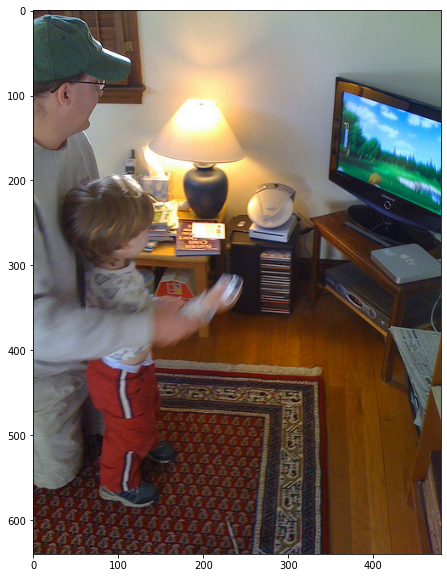

In [ ]:
img_pos = 256
img_id = train_json['images'][img_pos]['id']
cat2ibs = stats.img2cat2ibs[img_id]
img_fname = stats.img2fname[img_id]
img = Image.open(img_dir/img_fname)
plt.figure(figsize=(16,10))
plt.imshow(img)
img_id, img_fname, cat2ibs

## Overlay Boxes and Labels from Annotation

Let's overlay bounding boxes and labels over the image to confirm our understanding of the data.

In [ ]:
#export

def bbox_to_rect(ibbox, color):
    return plt.Rectangle(
        xy=(ibbox[1], ibbox[2]), width=ibbox[3], height=ibbox[4],
        fill=False, edgecolor=color, linewidth=2)

def label_for_bbox(ibbox, label, color):
    return plt.text(ibbox[1], ibbox[2], f"{ibbox[0]}.{label}", color=color, fontsize=16)

def overlay_img_bbox(img:Image, cat2ibs: dict, cat2name: dict):
    cat2color = { cid: cname for (cid, cname) in zip(cat2ibs.keys(), mcolors.TABLEAU_COLORS.keys()) }
    fig = plt.figure(figsize=(16,10))
    fig = plt.imshow(img)
    for cid, ibs in cat2ibs.items():
        for ib in ibs:
            label_for_bbox(ib, cat2name[cid], cat2color[cid])
            fig.axes.add_patch(bbox_to_rect(ib, cat2color[cid]))

Pick some random image to test drive the box overlay code...

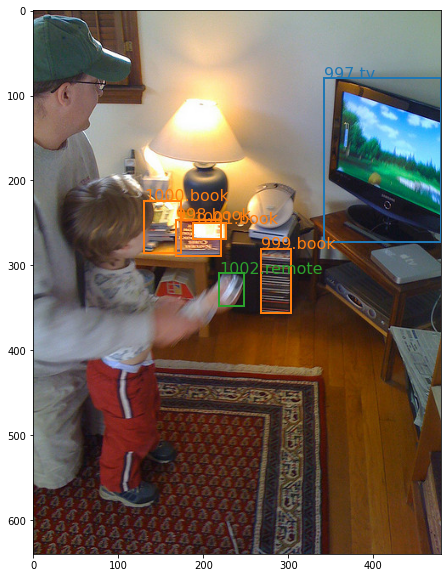

In [ ]:
img = Image.open(img_dir/stats.img2fname[img_id])
overlay_img_bbox(img, stats.img2cat2ibs[img_id], stats.cat2name)

Looks good enough.

## Wrap Data Loading Logic using Pytorch-Lightning


Now we need to define a DataModule to encapsulate all the data loading logic. At first I thought I can reuse CocoDetect() from torchvision but it and downstream cocoapi expects json annotation file to be of this [format](https://cocodataset.org/#format-data):
```
annotation{
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}
```

Tiny Coco's train.json file only has a subset of the above fields:
```
“Annotations”: [
    {
      "image_id": 542959,
      "bbox": [
        32.52,
        86.34,
        8.53,
        9.41
      ],
      "category_id": 62
    },
    ...
]
``` 

Thus we will need to make a Dataset to handle it properly.

In [ ]:
# export
    
class SubCocoDataset(torchvision.datasets.VisionDataset):
    """
    Simulate what torchvision.CocoDetect() returns for target given fastai's coco subsets
    Args:
        root (string): Root directory where images are downloaded to.
        stats (CocoDatasetStats): 
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(self, root, stats, transform=None, target_transform=None, transforms=None):
        super(SubCocoDataset, self).__init__(root, transforms, transform, target_transform)
        self.stats = stats
        self.img_ids = list(stats.img2fname.keys())

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        img_id = self.img_ids[index] if index < len(self.img_ids) else 0
        img_fname = self.stats.img2fname.get(img_id, None)
        if img_id == None or img_fname ==None:
            return (None, None)
        
        img = Image.open(os.path.join(self.root, img_fname)).convert('RGB')
        target = { "boxes": [], "labels": [], "image_id": None, "area": [], "iscrowd": 0, "ids": [] }
        count = 0
        liibs = self.stats.img2liibs.get(img_id,[])
        for cat_id, img_id, anno_id, x, y, w, h in liibs:
            count += 1
            target["boxes"].append([x, y, x+w, y+h])
            target["labels"].append(self.stats.cat2lbl[cat_id])
            target["image_id"] = img_id
            target["area"].append(w*h)
            target["ids"].append(anno_id)

        for k, v in target.items():
            target[k] = torch.tensor(v)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        else:
            if self.transform is not None: img = self.transform(img)
            if self.target_transform is not None: target = self.target_transform(target)

        return img, target

    def __len__(self):
        return self.stats.num_imgs

Test the SubCocoDataset

In [ ]:
tfm = transforms.Compose([ transforms.ToTensor() ])
fcoll = lambda batch: tuple(zip(*batch))

dataset = SubCocoDataset(img_dir, stats, transform=tfm)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=1, collate_fn=fcoll)
# For Training
images,targets = next(iter(data_loader))
(images), (targets)

((tensor([[[0.3961, 0.3804, 0.3608,  ..., 0.3490, 0.3569, 0.3569],
           [0.3882, 0.3804, 0.3569,  ..., 0.3490, 0.3608, 0.3647],
           [0.3843, 0.3804, 0.3647,  ..., 0.3490, 0.3608, 0.3647],
           ...,
           [0.1059, 0.1098, 0.1176,  ..., 0.3529, 0.3412, 0.3529],
           [0.1059, 0.1176, 0.1137,  ..., 0.3490, 0.3412, 0.3529],
           [0.0980, 0.1137, 0.1059,  ..., 0.3569, 0.3490, 0.3686]],
  
          [[0.3412, 0.3333, 0.3216,  ..., 0.3490, 0.3569, 0.3569],
           [0.3255, 0.3255, 0.3176,  ..., 0.3490, 0.3608, 0.3647],
           [0.3216, 0.3255, 0.3255,  ..., 0.3490, 0.3608, 0.3647],
           ...,
           [0.0980, 0.1020, 0.1098,  ..., 0.2824, 0.2745, 0.2745],
           [0.1059, 0.1176, 0.1137,  ..., 0.2824, 0.2627, 0.2745],
           [0.1059, 0.1216, 0.1137,  ..., 0.2784, 0.2706, 0.2863]],
  
          [[0.2275, 0.2314, 0.2235,  ..., 0.3490, 0.3569, 0.3569],
           [0.2235, 0.2235, 0.2196,  ..., 0.3490, 0.3608, 0.3647],
           [0.2196, 0.

Now wrap the Dataset into a DataModule...

In [ ]:
#export

class SubCocoDataModule(LightningDataModule):

    def __init__(self, root, stats, bs=32, workers=4, split_ratio=0.8):
        super().__init__()
        self.dir = root
        self.bs = bs
        self.workers = workers 
        self.stats = stats
        self.split_ratio = split_ratio
        
        # transforms for images
        transform=transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(stats.chn_means, stats.chn_stds)
        ])

        # prepare transforms for coco object detection
        dataset = SubCocoDataset(self.dir, self.stats, transform=transform)
        num_items = len(dataset)
        num_train = int(self.split_ratio*num_items)
        self.train, self.val = random_split(dataset, (num_train, num_items-num_train), generator=torch.Generator().manual_seed(42))
        # print(self.train, self.val)

    def collate_fn(self, batch):
        return tuple(zip(*batch))
    
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn)

Test the DataModule

In [ ]:
tiny_coco_dm = SubCocoDataModule(img_dir, stats, bs=2)
tdl=tiny_coco_dm.train_dataloader()
images, targets = next(iter(tdl))
len(images), len(targets)

(2, 2)

## Neural Network Architecture Model

There are Many object detection models to choose from.

To break my anaylysis paralysis researching and deciding between the various models and architectures, I decided to push ahead with what is provided by TorchVision out of the box i.e. Faster R-CNN with pretrained ResNet backbone. 

Luckily there is a turorial to follow
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

First, let's just use the raw model directly and verify the outputs

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, stats.num_cats)

In [ ]:
tdl = tiny_coco_dm.train_dataloader()
images, targets = next(iter(tdl))
images = list(img for img in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# how to get both in 1 step?
model.train()
losses = model(images,targets) 
model.eval()
predict = model(images)
(predict, losses)

([{'boxes': tensor([[0.0000e+00, 5.9830e+02, 3.0841e+01, 6.2442e+02],
           [4.5245e+02, 2.7496e+02, 6.3686e+02, 5.6072e+02],
           [0.0000e+00, 5.5253e+02, 2.6122e+02, 6.1490e+02],
           [2.8448e+02, 3.2195e+02, 6.3417e+02, 5.7434e+02],
           [0.0000e+00, 2.3512e+02, 2.6013e+02, 5.7570e+02],
           [0.0000e+00, 1.5157e+01, 2.4709e+02, 1.0908e+02],
           [4.5358e+02, 6.8236e+01, 6.3906e+02, 3.6003e+02],
           [4.5398e+02, 1.7021e+02, 6.3909e+02, 4.6240e+02],
           [0.0000e+00, 6.0560e+02, 2.2771e+01, 6.2904e+02],
           [3.2597e+02, 4.3899e+02, 6.3916e+02, 5.4508e+02],
           [0.0000e+00, 4.4349e+02, 2.5405e+02, 5.5226e+02],
           [5.5105e-01, 5.7737e+02, 3.5939e+01, 6.1613e+02],
           [0.0000e+00, 8.4339e+01, 2.5810e+02, 3.3321e+02],
           [0.0000e+00, 9.1006e+01, 2.5407e+02, 1.9415e+02],
           [0.0000e+00, 3.4696e+02, 2.5434e+02, 4.5024e+02],
           [0.0000e+00, 1.4223e+02, 2.5421e+02, 2.4546e+02],
           [0.0

## Metrics

In my initial attempt to port the example code Faster RCNN code to Pytorch-Lightning, I realized soon computing metrics is going to tricky. In fact, I don't actually know even what metrics to use!  Luckily someone pointed me to this well written [article by Raphael Padilla](https://github.com/rafaelpadilla/Object-Detection-Metrics) which explains the metrics used in object detection today. 

I decided to repurpose [CocoAPI](https://github.com/cocodataset/cocoapi/) which has builtin metric evaluation instead of rolling my own evaluation metrics.

It was painful as Coco API was not written for easy extension in mind.  For example, it tightly couples JSON file loading (and its format) into metrics computation, so I had to look under the cover for its implementation to then use it in a way that is probably not appropriate.  Also it tighly couple the computation of metrics with the batching of data.

I ended up just writing a wrapper that uses a separate Coco object for each ground truth and prediction, as if the whole epoch has only 1 sample. 

In [ ]:
# export

class SubCocoWrapper():
    def __init__(self, categories, p, t):
        # turn tgt: { "boxes": [...], "labels": [...], "image_id": "xxx", "area": [...], "iscrowd": 0 }
        # into COCO with dataset dict of this form:
        # { images: [], categories: [], annotations: [{"image_id": int, "category_id": int, "bbox": (x,y,width,height)}, ...] }
        # see https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
        with io.capture_output() as captured:
            self.target = COCO()
            img_id = int(t["image_id"]) # could be tensor, cast to int
            images = [ {'id': img_id, 'file_name': f"{img_id:012d}.jpg"} ]
            self.target.dataset["images"] = images
            self.target.dataset["categories"] = categories
            self.target.dataset["annotations"] = []
            for bi, b in enumerate(t["boxes"]):
                x, y, w, h = b
                cat_id = t["labels"][bi]
                anno_id = t["ids"][bi]
                self.target.dataset["annotations"].append({'id': anno_id, 'image_id': img_id, 'category_id': cat_id, 'bbox': b})
            self.target.createIndex()

            # [ {'boxes': tensor([[100.5,  39.7, 109.1,  52.7], [110.9,  41.1, 120.4,  54.4], [ 36.6,  56.1,  46.9,  74.0]], device='cuda:0'), 
            #    'labels': tensor([1, 1, 1], device='cuda:0'), 
            #    'scores': tensor([0.7800, 0.7725, 0.7648], device='cuda:0')}, ...]
            # numpy array [Nx7] of {imageID,x1,y1,w,h,score,class}
            pna = np.zeros((len(p["boxes"]), 7))
            for bi, b in enumerate(p["boxes"]):
                pna[bi]=(img_id, *b, p["scores"][bi], p["labels"][bi])

            anns = self.target.loadNumpyAnnotations(pna)
            self.prediction = COCO()
            self.prediction.dataset["images"] = images
            self.prediction.dataset["categories"] = categories
            self.prediction.dataset["annotations"] = anns

    def targetCoco(self): 
        return self.target
    
    def predictionCoco(self): 
        return self.prediction

Using the above wrapper, I can then compute the metric for the 1 sample epoch to get the metrics I want for the image
* Mean Average Precision (MAP)
* Mean Average Recall (MAR) 
* over a range of Intersection over Union (IOU) values from 50% to 95%
* then combined it using [F1](https://en.wikipedia.org/wiki/F1_score)

I should be able to use the above to do something like this:
```
    subcoco = SubCocoWrapper(categories, predictions, targets)
    cocoeval = COCOeval(subcoco.targetCoco(), subcoco.predictionCoco(), "bbox")
    cocoeval.evaluate()
    cocoeval.accumulate()
    cocoeval.summarize()
    precision = cocoeval.stats[0] # Average Precision (AP) @[ IoU=0.50:0.95 | area=all | maxDets=100 ]
    recall = cocoeval.stats[8] # Average Recall (AR) @[ IoU=0.50:0.95 | area=all | maxDets=100 ]
    f1 = 2/(1/precision + 1/recall) # see https://en.wikipedia.org/wiki/F1_score
```
But after messing with this for a few days, it doesn't seem to be working. My precision and recall is always coming back -1, so my f1 is also always -1. I suspect my understanding or usage of CocoEval is wrong... 

## Alternative Validation Metrics (not affecting training)

Decided to roll my own metrics by the following logic.

* pick all prediction boxes (pbox) with scores above cutoff score (scut) 
* compute all Intersection over Union (IoU) of all pbox and target boxes (tbox), take only pbox and tbox combo of IoU above IoU threshold (ithr)
* for each category C in target
    * true positives (TF): num box (pcat == tcat) above ithr
    * false positives (FP): num box (pcat != tcat) above ithr
    * precision = TP/(TP+FP), recall = TP/(TP+FN) or TP/(num target boxes of C)
    * F1 = 1/(1/prec + 1/recall)
* accuracy = weighted mean by num target boxes of all C's F1 score

In [ ]:
# export
def iou_calc(x1,y1,w1,h1, x2,y2,w2,h2):
    r1 = x1+w1 # right of box1
    b1 = y1+h1 # bottom of box1
    r2 = x2+w2 # right of box2
    b2 = y2+h2 # bottom of box2
    a1 = w1*h1
    a2 = w2*h2
    ia = 0. # intercept
    if x1 <= x2 <= r1:
        if y1 <= y2 <= b1:
            ia = (r1-x2)*(b1-y2)
        elif y1 <= b2 <= b1:
            ia = (r1-x2)*(b1-b2)
    elif x1 <= r2 <= r1:
        if y1 <= y2 <= b1:
            ia = (r1-r2)*(b1-y2)
        elif y1 <= b2 <= b1:
            ia = (r1-r2)*(b1-b2)
    iou = ia/(a1+a2-ia)
    # print(x1,y1,w1,h1, x2,y2,w2,h2,iou)
    return iou

def accuracy_1img(pred, tgt, scut=0.5, ithr=0.5):
    scut = 0.6
    ithr = 0.1
    pscores = pred['scores']
    pidxs = (pscores > scut).nonzero(as_tuple=True)
    pboxs = pred['boxes'][pidxs]
    tboxs = tgt['boxes']
    tls = tgt['labels']
    pls = pred['labels']
    tlset = {l for l in tls}
    
    tl2num = defaultdict(lambda:0)
    for tl in tls: tl2num[tl]+=1

    tlpls = []
    for tl,tb in zip(tls,tboxs):
        for pl,pb in zip(pls,pboxs):
            iou = iou_calc(*tb, *pb)
            # print(iou)
            if iou > ithr: tlpls.append((tl,pl))

    tl2tpfp = defaultdict(lambda: (0,0))
    for tl in tlset:
        for tl, pl in tlpls:
            tp, fp = tl2tpfp[tl]
            if tl == pl:
                tp+=1
            else:
                fp+=1
            tl2tpfp[tl] = (tp, fp)

    tl2f1 = {}
    for tl in tlset:
        tp, fp = tl2tpfp[tl]
        tlnum = tl2num[tl]
        precision = 0 if tp == 0 else tp/(tp+fp)
        recall = 0 if tp == 0 else tp/tlnum
        f1 = 0 if precision*recall == 0 else 2/(1/precision + 1/recall)
        tl2f1[tl] = f1
    
    acc = 0.
    tnum = len(tgt['boxes'])
    for tl, f1 in tl2f1.items():
        tlnum = tl2num[tl]
        f1 = tl2f1[tl]
        acc += f1*(tlnum/tnum)
    
    return acc

In [ ]:
acc = accuracy_1img(predict[0], targets[0], .1, .1)
acc

0.0

In [ ]:
# export

class FRCNN(LightningModule):
    def __init__(self, lbl2cat):
        super(FRCNN, self).__init__()
        self.categories = [ {'id': lid, 'name': f"{cid}" } for lid, cid in lbl2cat.items() ]
        self.num_classes = len(self.categories)  
        
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        
        # lock the pretrained model body
        for param in self.model.parameters():
            param.requires_grad = False
            
        # get number of input features for the classifier
        self.in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        
        # replace the pre-trained head with a new one, which is trainable
        self.model.roi_heads.box_predictor = FastRCNNPredictor(self.in_features, self.num_classes)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        losses = self.model(x, y)
        loss = sum(losses.values())
        result = TrainResult(loss)
        result.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return result

    def metrics(self, preds, targets):
        accu = torch.zeros((len(preds), 1))
        for i, (p,t) in enumerate(zip(preds, targets)):
            accu[i] = accuracy_1img(p, t, .3, .3)
        return torch.tensor(accu)
        
    def validation_step(self, val_batch, batch_idx):
        # validation runs the model in eval mode, so Y is prediction, not losses
        xs, ys = val_batch
        preds = self.model(xs, ys)
        accu = self.metrics(preds, ys)
        return {'val_acc': accu} # should add 'val_acc' accuracy e.g. MAP, MAR etc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch, but gradient accumulation may result in last row being different size
        val_accs = np.concatenate([ (o['val_acc']).numpy() for o in outputs ])
        avg_acc = val_accs.mean()
        tensorboard_logs = {'val_acc': avg_acc}
        return {'val_acc': avg_acc, 'logs': tensorboard_logs}
        
    def forward(self, x):
        self.model.eval()
        pred = self.model(x)
        return pred

In [ ]:
frcnn_model = FRCNN(stats.lbl2cat)

From earlier experimentation, I can average 1 epoc every 23 minutes or so, let's go for 30 epocs...

In [ ]:
# on my small GPU W/ 4GB VRAM, I can only fit bs=3 for tiny_coco, won't fit even 1 for sample_coco
# on my GCP w/ V100 of 16GB VRAM, I can fit bs=32 for tiny_coco, 16 for sample_coco
# either case I am using gradient accumulation to get more than 32 or more images in a minibatch
subcoco_dm = SubCocoDataModule(img_dir, stats, bs=16) 
chkpt_cb = ModelCheckpoint(
    filepath=f"model/{froot}.ckpt",
    save_last=True,
    monitor='val_acc',
    mode='max'
)
# train
trainer = Trainer(gpus=1, max_epochs=1, checkpoint_callback=chkpt_cb, accumulate_grad_batches=2)
trainer.fit(frcnn_model, subcoco_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41 M  


<ipython-input-75-7e02b6796500>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(accu)


Saving latest checkpoint..


1

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --host "0.0.0.0" 

Reusing TensorBoard on port 6006 (pid 33602), started 0:08:42 ago. (Use '!kill 33602' to kill it.)

## Inference

Time to see how well the model can perform.

In [ ]:
img = dataset[256]
img[0].shape

torch.Size([3, 640, 480])

In [ ]:
frcnn_model.eval()
pred = frcnn_model([img[0]])
pred

[{'boxes': tensor([[170.2418, 184.7082, 233.1296, 231.5653],
          [367.1316, 101.8637, 480.0000, 226.7932],
          [362.6497,  48.1658, 480.0000, 261.6468],
          [251.8929, 203.8460, 311.8161, 247.2805],
          [359.6780, 154.2703, 480.0000, 349.5747],
          [379.1616, 146.8233, 410.0220, 180.7644],
          [305.0192,  45.8801, 480.0000, 333.6426],
          [363.9466, 130.5295, 374.4799, 169.3296],
          [231.0659,  17.6110, 480.0000, 253.7983],
          [362.7221, 131.9545, 374.5165, 166.0266],
          [300.7805,  96.8939, 480.0000, 227.3642],
          [345.7189, 151.3828, 480.0000, 242.1471],
          [138.7652, 506.6109, 170.8415, 529.4283],
          [361.9186, 112.1727, 477.1960, 336.2935],
          [ 49.1861, 147.9282,  77.4863, 196.0168],
          [377.1942, 146.9004, 409.4063, 176.1570],
          [  0.0000,  41.1207, 125.6292, 332.6175],
          [236.7356,  20.1125, 480.0000, 297.1318],
          [367.9718, 192.3624, 480.0000, 542.4286],
   

In [ ]:
#export
def digest_pred(l2c, pred, cutoff=0.5):
    scores = pred['scores']
    pass_idxs = (scores > cutoff).nonzero(as_tuple=False)
    lbls = pred['labels'][pass_idxs]
    bboxs = pred['boxes'][pass_idxs]
    c2ibs = defaultdict(lambda: [])
    for i,lb in enumerate(zip(lbls, bboxs)):
        l,b = lb
        x,y,w,h = b[0]
        c = l2c[l.item()]
        ibs = c2ibs[c]
        ibs.append((i,x.item(),y.item(),w.item(),h.item()))
        c2ibs[c] = ibs
    return c2ibs

In [ ]:
pred_c2ibs = digest_pred(stats.lbl2cat, pred[0], cutoff=0.5)
pimg = torchvision.transforms.ToPILImage()(img[0])

In [ ]:
pred_c2ibs.keys()

dict_keys([62, 84])

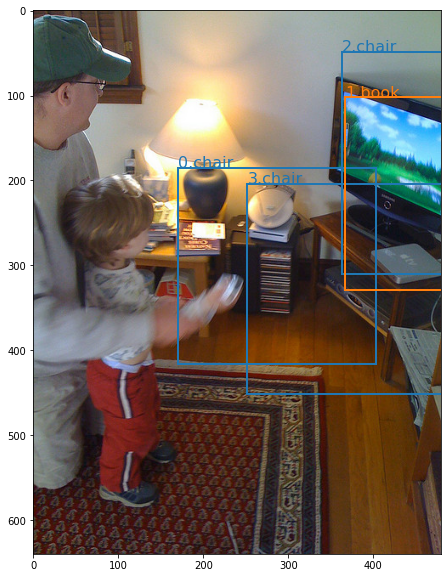

In [ ]:
overlay_img_bbox(pimg, pred_c2ibs, stats.cat2name)

## Saving Model Explicitly using Pytorch Lightning

Since the checkpoint logic is not saving properly as the validation metric wasn't improving, I am saving it explicitly after my training.

In [ ]:
model_save_path = f"model/{froot}.saved"
trainer.save_checkpoint(model_save_path)

## Reconstitude from Saved Model using Pytorch Lightning

Now let's reload from checkpoint to see if all works...

In [ ]:
pretrained_model = FRCNN.load_from_checkpoint(model_save_path)
pretrained_model.eval()

RuntimeError: Error(s) in loading state_dict for FRCNN:
	size mismatch for model.roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([7, 1024]) from checkpoint, the shape in current model is torch.Size([0, 1024]).
	size mismatch for model.roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([0]).
	size mismatch for model.roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([28, 1024]) from checkpoint, the shape in current model is torch.Size([0, 1024]).
	size mismatch for model.roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([0]).

## Saving and Reloading using Underlying Pytorch if above fails

In [ ]:
torch.save(frcnn_model.model.state_dict(), model_save_path)

In [ ]:
pretrained_model = FRCNN(stats.lbl2cat)
pretrained_model.model.load_state_dict(torch.load(model_save_path))
pretrained_model.freeze()

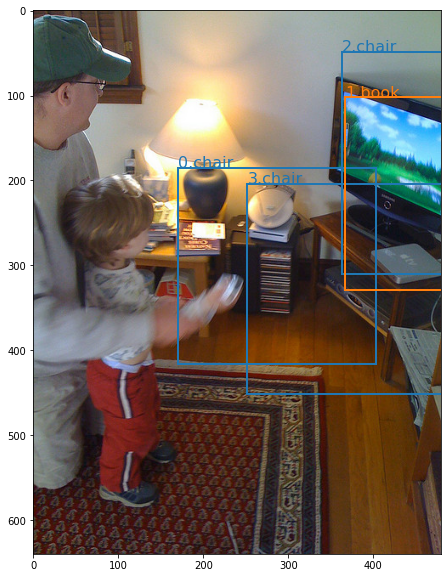

In [ ]:
pred = pretrained_model([img[0]])
pred_c2ibs = digest_pred(stats.lbl2cat, pred[0])
pimg = torchvision.transforms.ToPILImage()(img[0])

overlay_img_bbox(pimg, pred_c2ibs, stats.cat2name)

## Productionize
Export to ONNX and reloading after seems simple enough...

In [ ]:
onnx_save_path = "model/frcnn-oonx.onnx"
frcnn_model.to_onnx(onnx_save_path, torch.randn((1, 3, 128, 128)))
ort_session = onnxruntime.InferenceSession(onnx_save_path)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: img[0].numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs

/home/brian_guan_gmail_com/.local/lib/python3.8/site-packages/torch/tensor.py:452: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  warnings.warn('Iterating over a tensor might cause the trace to be incorrect. '
/home/brian_guan_gmail_com/.local/lib/python3.8/site-packages/torch/nn/functional.py:3009: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [(torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i],
/home/brian_guan_gmail_com/.local/lib/python3.8/site-packages/torchvision/models/detection/rpn.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

RuntimeError: Failed to export an ONNX attribute 'onnx::Sub', since it's not constant, please try to make things (e.g., kernel size) static if possible